# Efficiently searching for optimal tuning parameters


## Agenda

- How can K-fold cross-validation be used to search for an **optimal tuning parameter**?
- How can this process be made **more efficient**?
- How do you search for **multiple tuning parameters** at once?
- What do you do with those tuning parameters before making **real predictions**?
- How can the **computational expense** of this process be reduced?

## Review of K-fold cross-validation

Steps for cross-validation:

- Dataset is split into K "folds" of **equal size**
- Each fold acts as the **testing set** 1 time, and acts as the **training set** K-1 times
- **Average testing performance** is used as the estimate of out-of-sample performance

Benefits of cross-validation:

- More **reliable** estimate of out-of-sample performance than train/test split
- Can be used for selecting **tuning parameters**, choosing between **models**, and selecting **features**

Drawbacks of cross-validation:

- Can be computationally **expensive**

## Review of parameter tuning using `cross_val_score`

**Goal:** Select the best tuning parameters (aka "hyperparameters") for KNN on the iris dataset

In [106]:
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [107]:
# read in the iris data
iris = load_iris()

# create X (features) and y (response)
X = iris.data
y = iris.target

### KNeighborsClassifier with n_neighbors=5

Lets use *n_neighbors=5* as the starting point.  There are two parameters to KNeighborsClassifier that we will work with to see if we can improve the model performance:

- n_neighbors
- weights

There are other parameters to adjust, but to understand how **GridSearchCV** works we will only focus on those two.

In [108]:
# 10-fold cross-validation with K=5 for KNN (the n_neighbors parameter)
knn = KNeighborsClassifier(n_neighbors=5)

print(knn)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')


In [109]:

# Recall - that cross_val_score will use a stratified K-Fold strategy for classification models
scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
print(scores)

[1.         0.93333333 1.         1.         0.86666667 0.93333333
 0.93333333 1.         1.         1.        ]


In [110]:
# use average accuracy as an estimate of out-of-sample accuracy
print(scores.mean())

0.9666666666666668


### Manually Searching for the best n_neighbors value

We know from above how n_neighbors=5 performs, but is that the best parameter value to use.  

Lets create a loop and manually determine the best n_neighbors in the range of 1-31 to use.

In [111]:
# search for an optimal value of K for KNN
k_range = list(range(1, 31))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
print(*list(zip(range(1,31),k_scores)), sep='\n')


(1, 0.96)
(2, 0.9533333333333334)
(3, 0.9666666666666666)
(4, 0.9666666666666666)
(5, 0.9666666666666668)
(6, 0.9666666666666668)
(7, 0.9666666666666668)
(8, 0.9666666666666668)
(9, 0.9733333333333334)
(10, 0.9666666666666668)
(11, 0.9666666666666668)
(12, 0.9733333333333334)
(13, 0.9800000000000001)
(14, 0.9733333333333334)
(15, 0.9733333333333334)
(16, 0.9733333333333334)
(17, 0.9733333333333334)
(18, 0.9800000000000001)
(19, 0.9733333333333334)
(20, 0.9800000000000001)
(21, 0.9666666666666666)
(22, 0.9666666666666666)
(23, 0.9733333333333334)
(24, 0.96)
(25, 0.9666666666666666)
(26, 0.96)
(27, 0.9666666666666666)
(28, 0.9533333333333334)
(29, 0.9533333333333334)
(30, 0.9533333333333334)


From the list above we can see that .98 is largest value and it occured with n_neighbors equal to 13, 18, and 20

Let see how that looks graphically.

Text(0,0.5,'Cross-Validated Accuracy')

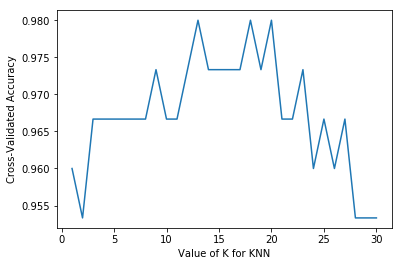

In [112]:
# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

You can clearly see that n_neighbors=5, while providing a good accuracy score, is not that best we can do.  we can actually do much better with a different value of k.

Lets use use **GridSearchCV** to show how we can performance the same analysis.

## More efficient parameter tuning using `GridSearchCV`

Allows you to define a **grid of parameters** that will be **searched** using K-fold cross-validation

Even when using **GridSearchCV**, you must still **split your data into a training set and a testing set** to avoid the possibility of overfitting the model.  The reason is you cannot use all of the data when trying to determine the optimial parameters. 

This is rarely pointed out in blog posts, but was mentioned in the book:

Introduction to Machine Learning with Python: A Guide for Data Scientists
- Book by Andreas Muller and Sarah Guido is a very consumeable guide to machine learning with great insight into the field.

on page 268.  

We will perform a *train_test_split* and hold out the test set so that we can perform a score calculation after the training set is used to find the optimal model parameters.


### Important Attributes
- cv_results_
- best_estimator_
- best_score_
- best_params_


In [113]:
from sklearn.model_selection import GridSearchCV

In this example, only search for the best value for a single parameter, n_neighbors

In [114]:
# define the parameter values that should be searched
k_range = list(range(1, 31))
print(k_range)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


GridSearchCV takes a dictionary of parameters to apply to the model.  The keys in the dictionary correspond to the parameter names, and the values in the dictionary represent the collection of values that GridSearchCV should try.  If there are multiple entries in the dictionary then GridSearchCV will try every combination of values.

For this reason, GridSearchCV can be very computationally expensive and time expensive.

In [115]:
# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(n_neighbors=k_range)
print(param_grid)

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]}


#### GridSearchCV

This function will take a model, a parameter dictionary of all of the parameters to try and the cross fold to find the best combination of model parameters.

In this example, we are creating a parameter dictionary with just the *n_neighbors* parameter with the values 1 to 30.  GridSearchCV will use this to perform the model evaluation and find the best model based on the scoring parameter which we have set to *accuracy*

Recall that the *CrossValidation* will either be a StratifiedCrossValidation for Classification models, or a K-Fold CrossValidation for Regression models

In [116]:
# instantiate the grid
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=True)

- You can set **`n_jobs = -1`** to run computations in parallel (if supported by your computer and OS)

#### GridSearchCV has the same API as any SciKit Learn model.  

Therfore 'fit' and 'predict' methods are available on GridSearchCV

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

When we call *fit* on the *GridSearchCV* instance, that method will run through all of the parameters to determine the best parameters for the model.  

Because GridSearchCV has the same interface as any model, we can call fit, predict, score, etc.

In [118]:
# fit the grid with data
grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=30, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [119]:
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']

# To get the equivalent of grid_scores_ ( which is deprecated )
for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    print("mean: %0.3f (+/-%0.03f) params: %r"% (mean, std * 2, params))


mean: 0.950 (+/-0.111) params: {'n_neighbors': 1}
mean: 0.942 (+/-0.130) params: {'n_neighbors': 2}
mean: 0.958 (+/-0.111) params: {'n_neighbors': 3}
mean: 0.958 (+/-0.108) params: {'n_neighbors': 4}
mean: 0.958 (+/-0.113) params: {'n_neighbors': 5}
mean: 0.967 (+/-0.080) params: {'n_neighbors': 6}
mean: 0.958 (+/-0.082) params: {'n_neighbors': 7}
mean: 0.967 (+/-0.110) params: {'n_neighbors': 8}
mean: 0.967 (+/-0.079) params: {'n_neighbors': 9}
mean: 0.975 (+/-0.106) params: {'n_neighbors': 10}
mean: 0.975 (+/-0.074) params: {'n_neighbors': 11}
mean: 0.967 (+/-0.109) params: {'n_neighbors': 12}
mean: 0.975 (+/-0.074) params: {'n_neighbors': 13}
mean: 0.958 (+/-0.079) params: {'n_neighbors': 14}
mean: 0.975 (+/-0.075) params: {'n_neighbors': 15}
mean: 0.967 (+/-0.078) params: {'n_neighbors': 16}
mean: 0.975 (+/-0.075) params: {'n_neighbors': 17}
mean: 0.950 (+/-0.108) params: {'n_neighbors': 18}
mean: 0.950 (+/-0.109) params: {'n_neighbors': 19}
mean: 0.950 (+/-0.109) params: {'n_neigh

In [120]:
print(grid.cv_results_['params'][0])
print(grid.cv_results_['split0_test_score'])
print(grid.cv_results_['mean_test_score'][0])


{'n_neighbors': 1}
[1.         1.         1.         1.         1.         1.
 0.92307692 1.         0.92307692 1.         0.92307692 1.
 0.92307692 0.92307692 0.92307692 0.92307692 0.92307692 0.92307692
 0.92307692 0.92307692 0.92307692 0.92307692 0.92307692 0.92307692
 0.92307692 0.92307692 0.92307692 0.92307692 0.92307692 0.92307692]
0.95


In [121]:
# create a list of the mean scores only
grid_mean_scores = [result for result in grid.cv_results_['mean_test_score']]
print(grid_mean_scores)

[0.95, 0.9416666666666667, 0.9583333333333334, 0.9583333333333334, 0.9583333333333334, 0.9666666666666667, 0.9583333333333334, 0.9666666666666667, 0.9666666666666667, 0.975, 0.975, 0.9666666666666667, 0.975, 0.9583333333333334, 0.975, 0.9666666666666667, 0.975, 0.95, 0.95, 0.95, 0.95, 0.95, 0.9416666666666667, 0.9416666666666667, 0.9416666666666667, 0.9416666666666667, 0.9583333333333334, 0.9583333333333334, 0.9416666666666667, 0.9416666666666667]


Text(0,0.5,'Cross-Validated Accuracy')

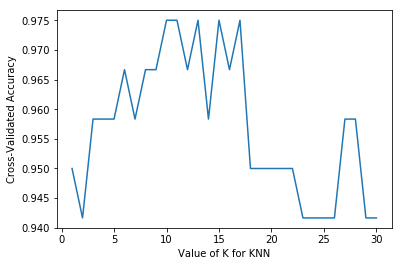

In [122]:
# plot the results
plt.plot(k_range, grid_mean_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

## Best Estimator

GridSearchCV has properties which will hold the best score, params and estimator.

In [123]:
# examine the best model
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.975
{'n_neighbors': 10}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')


Lets use the best estimator model with the test set and calculation the score on data the model has never seen.

In [124]:
score = grid.best_estimator_.score(X_test, y_test)
print(score)

0.9666666666666667


## Searching multiple parameters simultaneously

- Search across 'k' values from 1 - 30
- Search across weights between 'uniform' and 'distance'


In [47]:
# define the parameter values that should be searched
k_range = list(range(1, 31))
weight_options = ['uniform', 'distance']

In [48]:
# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(n_neighbors=k_range, weights=weight_options)
print(param_grid)

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], 'weights': ['uniform', 'distance']}


In [49]:
# instantiate and fit the grid
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
%time grid.fit(X, y)

CPU times: user 1.16 s, sys: 6.21 ms, total: 1.16 s
Wall time: 1.16 s


GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=30, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [50]:
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']

top_scores = []
# To get the equivalent of grid_scores_ ( which is deprecated )
for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    print("mean: %0.3f (+/-%0.03f) params: %r"% (mean, std * 2, params))
    if mean >= 0.979:
        top_scores.append((mean, std*2, params))


mean: 0.960 (+/-0.107) params: {'n_neighbors': 1, 'weights': 'uniform'}
mean: 0.960 (+/-0.107) params: {'n_neighbors': 1, 'weights': 'distance'}
mean: 0.953 (+/-0.104) params: {'n_neighbors': 2, 'weights': 'uniform'}
mean: 0.960 (+/-0.107) params: {'n_neighbors': 2, 'weights': 'distance'}
mean: 0.967 (+/-0.089) params: {'n_neighbors': 3, 'weights': 'uniform'}
mean: 0.967 (+/-0.089) params: {'n_neighbors': 3, 'weights': 'distance'}
mean: 0.967 (+/-0.089) params: {'n_neighbors': 4, 'weights': 'uniform'}
mean: 0.967 (+/-0.089) params: {'n_neighbors': 4, 'weights': 'distance'}
mean: 0.967 (+/-0.089) params: {'n_neighbors': 5, 'weights': 'uniform'}
mean: 0.967 (+/-0.089) params: {'n_neighbors': 5, 'weights': 'distance'}
mean: 0.967 (+/-0.089) params: {'n_neighbors': 6, 'weights': 'uniform'}
mean: 0.967 (+/-0.089) params: {'n_neighbors': 6, 'weights': 'distance'}
mean: 0.967 (+/-0.089) params: {'n_neighbors': 7, 'weights': 'uniform'}
mean: 0.967 (+/-0.089) params: {'n_neighbors': 7, 'weights

In [51]:
# examine the best model
print(grid.best_score_)
print(grid.best_params_)

0.98
{'n_neighbors': 13, 'weights': 'uniform'}


In [52]:
# Note that the same score was achieved with muliple different parameters.
for top_score in top_scores:
    print(top_score)

(0.98, 0.06110100926607785, {'n_neighbors': 13, 'weights': 'uniform'})
(0.98, 0.06110100926607785, {'n_neighbors': 15, 'weights': 'distance'})
(0.98, 0.06110100926607785, {'n_neighbors': 17, 'weights': 'distance'})
(0.98, 0.06110100926607785, {'n_neighbors': 18, 'weights': 'uniform'})
(0.98, 0.06110100926607785, {'n_neighbors': 19, 'weights': 'distance'})
(0.98, 0.06110100926607785, {'n_neighbors': 20, 'weights': 'uniform'})
(0.98, 0.06110100926607785, {'n_neighbors': 27, 'weights': 'distance'})


## Using the best parameters to make predictions

In [53]:
# train your model using all data and the best known parameters
knn = KNeighborsClassifier(n_neighbors=13, weights='uniform')
knn.fit(X, y)

# make a prediction on out-of-sample data
knn.predict([[3, 5, 4, 2]])

array([1])

In [54]:
# shortcut: GridSearchCV automatically refits the best model using all of the data
grid.predict([[3, 5, 4, 2]])

array([1])

## Reducing computational expense using `RandomizedSearchCV`

- Searching many different parameters at once may be computationally infeasible
- `RandomizedSearchCV` searches a subset of the parameters, and you control the computational "budget"

In [55]:
from sklearn.grid_search import RandomizedSearchCV

In [56]:
# specify "parameter distributions" rather than a "parameter grid"
param_dist = dict(n_neighbors=k_range, weights=weight_options)

- **Important:** Specify a continuous distribution (rather than a list of values) for any continous parameters

In [57]:
# n_iter controls the number of searches
rand = RandomizedSearchCV(knn, param_dist, cv=10, scoring='accuracy', n_iter=10, random_state=5)
rand.fit(X, y)
rand.grid_scores_

[mean: 0.97333, std: 0.03266, params: {'weights': 'distance', 'n_neighbors': 16},
 mean: 0.96667, std: 0.03333, params: {'weights': 'uniform', 'n_neighbors': 22},
 mean: 0.98000, std: 0.03055, params: {'weights': 'uniform', 'n_neighbors': 18},
 mean: 0.96667, std: 0.04472, params: {'weights': 'uniform', 'n_neighbors': 27},
 mean: 0.95333, std: 0.04269, params: {'weights': 'uniform', 'n_neighbors': 29},
 mean: 0.97333, std: 0.03266, params: {'weights': 'distance', 'n_neighbors': 10},
 mean: 0.96667, std: 0.04472, params: {'weights': 'distance', 'n_neighbors': 22},
 mean: 0.97333, std: 0.04422, params: {'weights': 'uniform', 'n_neighbors': 14},
 mean: 0.97333, std: 0.04422, params: {'weights': 'distance', 'n_neighbors': 12},
 mean: 0.97333, std: 0.03266, params: {'weights': 'uniform', 'n_neighbors': 15}]

In [58]:
# examine the best model
print(rand.best_score_)
print(rand.best_params_)

0.98
{'weights': 'uniform', 'n_neighbors': 18}


In [59]:
# run RandomizedSearchCV 20 times (with n_iter=10) and record the best score
best_scores = []
for _ in range(20):
    rand = RandomizedSearchCV(knn, param_dist, cv=10, scoring='accuracy', n_iter=10)
    rand.fit(X, y)
    best_scores.append(round(rand.best_score_, 3))
print(best_scores)

[0.98, 0.98, 0.973, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.973, 0.98, 0.973, 0.973, 0.98, 0.98]


## Resources

- scikit-learn documentation: [Grid search](http://scikit-learn.org/stable/modules/grid_search.html), [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html), [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.RandomizedSearchCV.html)
- Timed example: [Comparing randomized search and grid search](http://scikit-learn.org/stable/auto_examples/model_selection/randomized_search.html)
- scikit-learn workshop by Andreas Mueller: [Video segment on randomized search](https://youtu.be/0wUF_Ov8b0A?t=17m38s) (3 minutes), [related notebook](https://github.com/amueller/pydata-nyc-advanced-sklearn/blob/master/Chapter%203%20-%20Randomized%20Hyper%20Parameter%20Search.ipynb)
- Paper by Yoshua Bengio: [Random Search for Hyper-Parameter Optimization](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf)